### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas_profiling import ProfileReport
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from pyvi import ViPosTagger, ViTokenizer
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\tinhdaubuoi\AppData\Local\Temp\ipykernel_20116\1494690340.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
df1 = pd.read_csv("comments.csv", encoding="utf-8")

In [3]:
df1.head()

,product_id,comment_id,title,thank_count,customer_id,rating,comment
0,74021317,12559756,Cực kì hài lòng,313,22051463,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,74021317,16979365,Cực kì hài lòng,6,27791831,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,74021317,14069617,Cực kì hài lòng,25,17748750,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,74021317,8569824,Cực kì hài lòng,57,410797,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,74021317,18368714,Cực kì hài lòng,0,28545286,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


In [4]:
df1.shape

(141281, 7)

In [5]:
df1['rating'].value_counts()

5    114514
4     14295
3      5276
1      4495
2      2701
Name: rating, dtype: int64

# CLASSIFICATION 

### POSITIVE

In [6]:
df_notlike = df1[df1['rating'] < 3 ]

In [7]:
df_notlike.value_counts()

product_id  comment_id  title               thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                  
527316      5688526     Không hài lòng      0            18990092     2       sách dơ, góc bị nhăn . Khá là buồn                                                                                                                                                                                                                                                                                           6
53095307    6786178     Không hài lòng      0            370250       2       sách mình mới mua dc vài hôm.hôm nay mở ra xem thì đã bị như thế này rồi. thật sự khá thật vọng. mong tiki xem xét lại khâu quản lí t

### NEUTRAL

In [8]:
df_neutral= df1[df1['rating'] == 3 ]

In [9]:
df_neutral.value_counts()

product_id  comment_id  title        thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
53095307    12442991    Bình thường  0            2097970      3       Một câu chuyện đề tài gia đình vô cùng ý nghĩa. Hàng giao nhanh, bìa đẹp, đóng gói cẩn thận                                                                                                        

### LIKE

In [10]:
df_like = df1[df1['rating'] > 3 ]

In [11]:
df_like.value_counts()

product_id  comment_id  title            thank_count  customer_id  rating  comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
527316      728193      Cực kì hài lòng  0            1466782      5       sản phẩm tốt,nhưng có điều là sách hơi bị bẩn nhưng mà có thể chấp nhận được vì sự tận tình của nhân viên giao hàng cũng như là giao hàng rất sớm.Rất tin tưởng tiki                                                    

### CHECK NAN VALUES

In [12]:
df2 = df1[["rating","comment"]].copy()

In [13]:
df2.isna().sum()

rating         0
comment    38018
dtype: int64

In [14]:
df2.isnull().sum()

rating         0
comment    38018
dtype: int64

In [15]:
df_isnull = df2[df2['comment'].isnull()]

In [16]:
df_count = df_isnull['rating'].value_counts()
df_result = pd.DataFrame(df_count)
df_result = df_result.reset_index()
df_result.columns = ['rating','value_counts']
print(df_result)

   rating  value_counts
0       5         35055
1       4          2906
2       3            45
3       1             9
4       2             3


#### Nhận xét
Phần lớn các comment chỉ đánh giá bằng rating và không nói gì thêm nằm ở mức số 5, tức là đại đa số khách hàng hài lòng sẽ không nói gì thêm. Ta có thể bỏ NaN values để bộ dữ liệu được cân bằng hơn.

In [17]:
df3 = df1[~df1['comment'].isnull()]

### CHECK AND DROP DUMPLICATES 

In [18]:
df3.duplicated().sum()

17264

In [19]:
df3.drop_duplicates(inplace=True)

In [20]:
for index, row in df3.sample(50).iterrows():
    print(row['comment'])

Sách bọc rất kỹ nhưng vẫn thấy vết sứt trên bìa, chữ in nhòe, ảnh phân giải thấp như download trên mạng dán vào. Sách căn lề sát mép, nhiều trang còn chưa xén hết. Cảm giác nhưng đang cầm tuyển tập photo chứ ko phải quyển sách. Lần đầu cũng có lẽ là lần cuối mua sách của Khang Việt.
Sách khổ to, có hơi bẩn 1 chút do k có màng bọc nilon bên ngoài nhưng không sao, nội dung rất phù hợp với những bạn trẻ đang ở lứa tuổi thanh niên
Mình mua 2 quyển với giá 145k
Tiki nay đã cẩn thận hơn trong khâu đóng hàng, có giấy chèn cẩn thận, k còn tình trạng sách bị lọc xọc trong hộp nữa
Mua dùm chị. Chị rất thích.
Giao nhanh 
Đóng gói sơ xài sách rất bẩn, ko có bọc trống sóc 
Lần đầu đặt TiKi về hộp thì chỉnh chu hơn Shopee nhưng mik ko đánh giá quá cao về chất lượng sản phẩm ko nói đến nội dung quyển sách mà sách rất bẩn.
nội dung bổ ích, sách hay
Đọc nửa cuốn đầu có nhiều đoạn khá hài hước, sau dần về lôi cuốn người đọc hơn.Sách có nội dung xen kẽ giữa hiện thực và quá khứ với nhiều nhân vật liên qu

In [21]:
df3.shape

(85999, 7)

### KEEP RATING COLUMN AND COMMENT COLUMN

In [22]:
df4 = df3[['rating','comment']]

In [23]:
conditions = [
    (df4['rating'] < 3),
    (df4['rating'] == 3),
    (df4['rating'] > 3)
]

values = ['negative', 'neutral', 'positive']

df4['class'] = np.select(conditions, values)
df4 = df4[['comment','class']]

In [24]:
df4.reset_index(drop=True, inplace=True)

In [25]:
df4.head()

,comment,class
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",positive
1,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",positive
2,"Bìa cực xinh, tiki giao hàng nhanh, sách không...",positive
3,"Sách lúc nhận hình thức rất ổn, không cong vên...",positive
4,Một cuốn sách rất đáng đọc về tình yêu thương ...,positive


In [26]:
df4.isnull().sum()

comment    0
class      0
dtype: int64

In [27]:
df4['class'].value_counts()

positive    76005
negative     5666
neutral      4328
Name: class, dtype: int64

<Axes: xlabel='class', ylabel='count'>

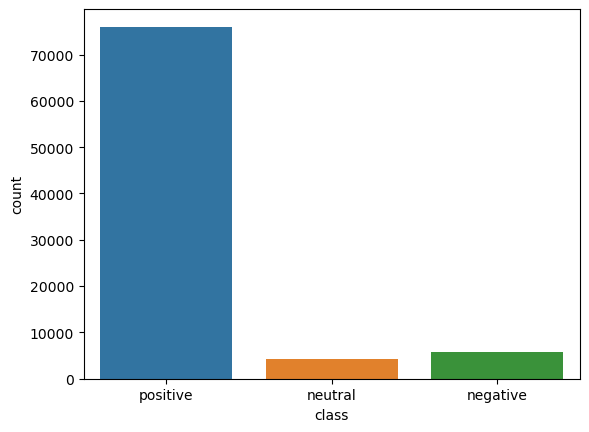

In [28]:
#visualize data
sns.countplot(x='class', data=df4)

## CLEAN TEXT

In [29]:
from xulyvni import *

### USE DASK FOR MULTIPLE PROCESSING

In [30]:
# Create a cluster
cluster = LocalCluster()
client = Client(cluster)
dask.config.set(scheduler='multiprocessing')

In [31]:
from xulyvni import xuly_vni

In [32]:
# CREATE DASK DATAFRAME FROM PANDAS DATAFRAME
ddf = dd.from_pandas(df4, npartitions=16)
ddf = ddf.map_partitions(xuly_vni)

In [33]:
# CONVERT DASK DF TO PANDAS DF
with ProgressBar():
    df = ddf.compute(num_workers=7)
del ddf

[########################################] | 100% Completed | 478.75 s


In [34]:
for index, row in df.sample(100).iterrows():
    print(row['processed_text'])

sách bị_gãy bám bẩn đầu sách bị_như hơi_không nội sách phân_tích tư_thế học đọc
sách đẹp nguyên bóc cũng_bị lớp góc bị_móp chỗ bó bình_thường hàng hãng đẹp
chờ sách sách bọc bìa méo bụi lắm đóng_gói hàng cũng_không tốt vận_chuyển trải_nghiệm không_tốt
sách bị_lỗi
bìa đẹp săn ẻm cười
hàng kịp đọc nội sơ_bộ chất_lượng giấy quá_tệ sách lậu
hàng sách đẹp không_bị hư_hại đỉm cười truyện cực như_cái truyện mèo nuôi_nấng chăm_sóc tập truyện ý_nghĩa lắm
dịch_vụ sách đóng gói bì kỹ đọc review sách rất_cười
sách đẹp
sách trình_bày ấn_tượng trứng khủng bé
vận_chuyển hộp rách góc sách móp méo như_này rất_không hài_lòng hàng
mặt bìa hơi_có vết cào méo mép
sách nxb app báo bọc plastic sách miếng xốp sách không_bị móp méo miếng sách cầm đầm bìa chữ_ký cứng_cáp bookmark bình_thường chất_liệu giấy sờ cực xịn đọc chương câu_chuyện quan_điểm tình_yêu rất_mới mẻ sách đọc phiên_bản vãn tình trừ rất_thích rất_thích sách tậu sách đầu cũng_đã thập hành_trình vãn tình trọn tác_giả sách cũng_đổi góc tư_tưởng th

In [35]:
df.reset_index(drop=True, inplace=True)

In [36]:
df_final = df[['processed_text','class']]

In [37]:
# COMMENTS HAVE LESS THAN 3 WORDS WILL BE REMOVED
df_final['word_count'] = df_final['processed_text'].apply(lambda x: len(str(x).split(" ")))
df_final = df_final[df_final['word_count'] > 2]
df_final['class'].value_counts()

positive    60447
negative     5283
neutral      4012
Name: class, dtype: int64

In [38]:
df_final.head()

,processed_text,class,word_count
0,lấp hạnh_phúc vết nứt ủi chữa vỡ trái câu_chuy...,positive,60
1,chê gói hàng quá_hàng không_bị hư tẹo hơi_sơ s...,positive,24
2,bìa cực hàng sách không_bị nhăn góc gãy cạnh b...,positive,64
3,sách hình_thức rất_ổn không_vênh xước gãy đơn ...,positive,44
4,sách rất_đáng đọc tình_yêu_thương mất_mát gợi_...,positive,55


In [39]:
df_final.to_csv('comments_final.csv')

## VISUALIZE

### Negative

In [40]:
df_final_notlike = df_final[df_final['class'] == 'negative' ]
wc_notlike = WordCloud(
    background_color='black',
    max_words=500
)
wc_notlike.generate(str(df_final_notlike['processed_text'].values))

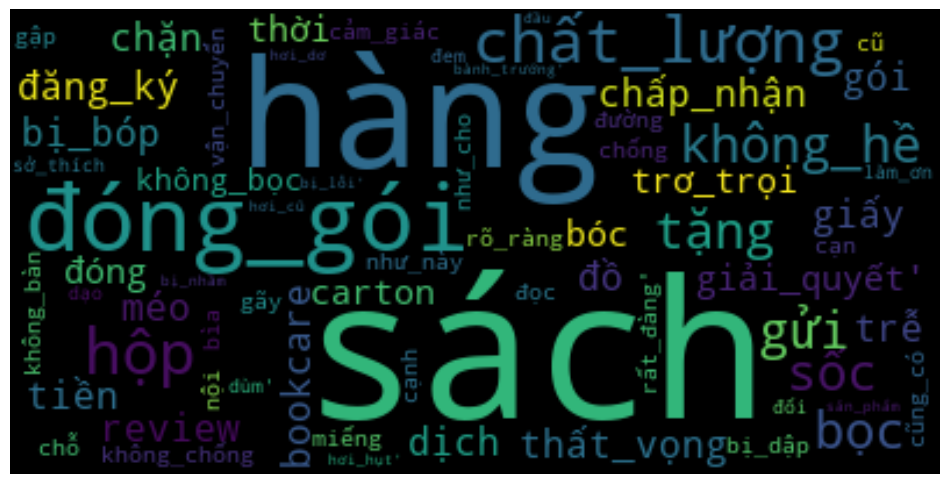

In [41]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral

In [42]:
df_final_neutral = df_final[df_final['class'] == 'neutral' ]
wc_neutral = WordCloud(
    background_color='black',
    max_words=500
)
wc_neutral.generate(str(df_final_neutral['processed_text'].values))

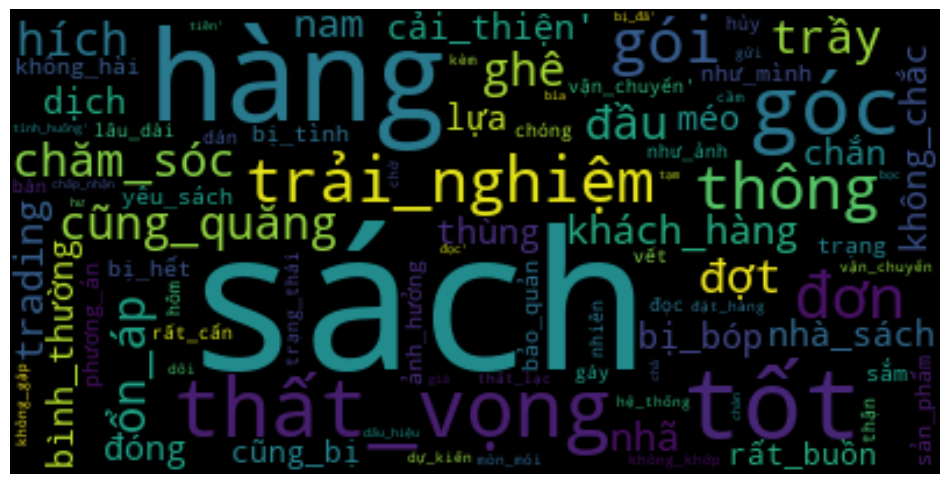

In [43]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.show()

### Positive

In [44]:
df_final_like = df_final[df_final['class'] == 'positive' ]
wc_like = WordCloud(
    background_color='black',
    max_words=500
)
wc_like.generate(str(df_final_like['processed_text'].values))

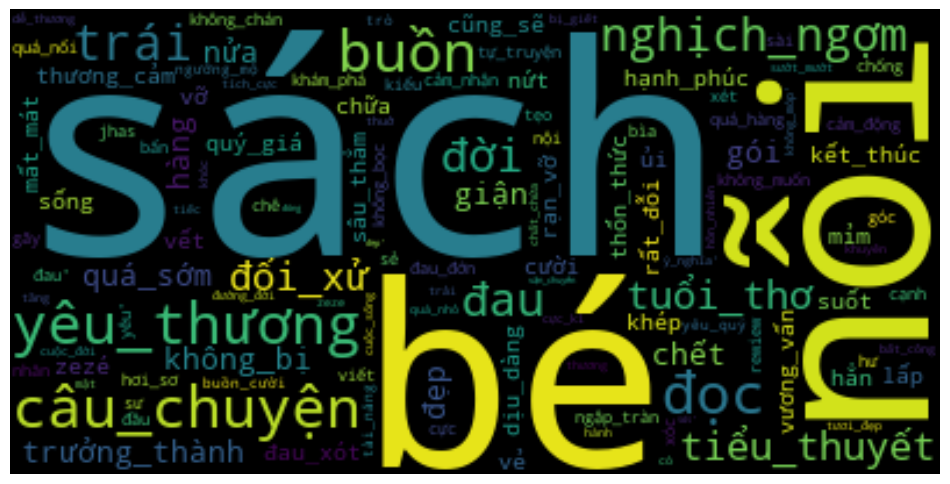

In [45]:
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear')
plt.axis('off')
plt.show()

Sau khi thực hiện quá trình tiền xử lí, nhận thấy bộ dữ liệu còn nhiều nội dung chưa chuẩn như hình thái chưa đúng với bình luận, chúng em đã xử lí bằng cách gán nhãn bằng tay cho hơn 35.000 câu.